In [15]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import KFold, StratifiedKFold
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

label_file = "hirise-v3-cv-dataset/hirise-text-labels.txt"
image_dir = "hirise-v3-cv-dataset/map-proj-v3"

In [16]:
train_data = pd.read_csv(label_file, delimiter="\s+")
Y = train_data[['label']]
print(Y)

kf = KFold(n_splits = 5)
                         
skf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True) 

       label
0      other
1      other
2      other
3      other
4      other
...      ...
73026  other
73027  other
73028  other
73029  other
73030  other

[73031 rows x 1 columns]


In [17]:
idg = ImageDataGenerator(rescale=1./255)
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

In [21]:
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
def create_new_model():
    model = Sequential()

    # 1st Convolutional Layer
    model.add(Conv2D(filters=96, input_shape=(227,227,3), kernel_size=(11,11), strides=(4,4), padding='valid'))
    model.add(Activation('relu'))
    # Max Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

    # 2nd Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Max Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

    # 3rd Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))

    # 4th Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))

    # 5th Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Max Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

    # Passing it to a Fully Connected layer
    model.add(Flatten())
    # 1st Fully Connected Layer
    model.add(Dense(4096, input_shape=(224*224*3,)))
    model.add(Activation('relu'))
    # Add Dropout to prevent overfitting
    model.add(Dropout(0.5))

    # 2nd Fully Connected Layer
    model.add(Dense(4096))
    model.add(Activation('relu'))
    # Add Dropout
    model.add(Dropout(0.5))

    # 3rd Fully Connected Layer
    model.add(Dense(1000))
    model.add(Activation('relu'))
    # Add Dropout
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(8))
    model.add(Activation('softmax'))
    return model

# The cell below trains the data and takes 1 hour 15 min. Don't run if you already have saved models!

In [25]:
VALIDATION_ACCURACY = []
VALIDATION_LOSS = []

save_dir = 'saved_models/'
fold_var = 1
n=73031
num_epochs = 10
img_width = 227
img_height = 227

for train_index, val_index in kf.split(np.zeros(n),Y):
	training_data = train_data.iloc[train_index]
	validation_data = train_data.iloc[val_index]
	
	train_data_generator = idg.flow_from_dataframe(training_data, directory = image_dir,
						       x_col = "filename", y_col = "label", target_size=(img_height, img_width),
						       class_mode = "categorical", shuffle = True)
	valid_data_generator  = idg.flow_from_dataframe(validation_data, directory = image_dir,
							x_col = "filename", y_col = "label", target_size=(img_height, img_width),
							class_mode = "categorical", shuffle = True)
	
	# CREATE NEW MODEL
	model = create_new_model()
	# COMPILE NEW MODEL
	model.compile(loss='categorical_crossentropy',
		      optimizer='adam',
		      metrics=['accuracy'])
	
	# CREATE CALLBACKS
	checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var), 
							monitor='val_accuracy', verbose=1, 
							save_best_only=True, mode='max')
	callbacks_list = [checkpoint]
	# There can be other callbacks, but just showing one because it involves the model name
	# This saves the best model
	# FIT THE MODEL
	history = model.fit(train_data_generator,
			    epochs=num_epochs,
			    callbacks=callbacks_list,
			    validation_data=valid_data_generator)
	#PLOT HISTORY
	#		:
	#		:
	
	# LOAD BEST MODEL to evaluate the performance of the model
	model.load_weights("saved_models/model_"+str(fold_var)+".h5")
	
	results = model.evaluate(valid_data_generator)
	results = dict(zip(model.metrics_names,results))
	
	VALIDATION_ACCURACY.append(results['accuracy'])
	VALIDATION_LOSS.append(results['loss'])
	
	tf.keras.backend.clear_session()
	
	fold_var += 1

Found 58424 validated image filenames belonging to 8 classes.
Found 14607 validated image filenames belonging to 8 classes.
Epoch 1/10
1825/1826 [============================>.] - ETA: 0s - loss: 0.7646 - accuracy: 0.8329
Epoch 1: val_accuracy improved from -inf to 0.84617, saving model to saved_models/model_1.h5


/home/riley/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1826/1826 [==============================] - 85s 46ms/step - loss: 0.7646 - accuracy: 0.8329 - val_loss: 0.6611 - val_accuracy: 0.8462
Epoch 2/10
1825/1826 [============================>.] - ETA: 0s - loss: 0.7361 - accuracy: 0.8335
Epoch 2: val_accuracy did not improve from 0.84617
1826/1826 [==============================] - 73s 40ms/step - loss: 0.7361 - accuracy: 0.8335 - val_loss: 0.6567 - val_accuracy: 0.8462
Epoch 3/10
1826/1826 [==============================] - ETA: 0s - loss: 0.7325 - accuracy: 0.8335
Epoch 3: val_accuracy did not improve from 0.84617
1826/1826 [==============================] - 100s 55ms/step - loss: 0.7325 - accuracy: 0.8335 - val_loss: 0.6590 - val_accuracy: 0.8462
Epoch 4/10
1825/1826 [============================>.] - ETA: 0s - loss: 0.7311 - accuracy: 0.8335
Epoch 4: val_accuracy did not improve from 0.84617
1826/1826 [==============================] - 83s 45ms/step - loss: 0.7312 - accuracy: 0.8335 - val_loss: 0.6539 - val_accuracy: 0.8462
Epoch 5/10
1

/home/riley/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1826/1826 [==============================] - 69s 37ms/step - loss: 0.7704 - accuracy: 0.8261 - val_loss: 0.5839 - val_accuracy: 0.8740
Epoch 2/10
1825/1826 [============================>.] - ETA: 0s - loss: 0.7544 - accuracy: 0.8265
Epoch 2: val_accuracy did not improve from 0.87396
1826/1826 [==============================] - 64s 35ms/step - loss: 0.7545 - accuracy: 0.8265 - val_loss: 0.5862 - val_accuracy: 0.8740
Epoch 3/10
1825/1826 [============================>.] - ETA: 0s - loss: 0.7503 - accuracy: 0.8265
Epoch 3: val_accuracy did not improve from 0.87396
1826/1826 [==============================] - 64s 35ms/step - loss: 0.7502 - accuracy: 0.8265 - val_loss: 0.5779 - val_accuracy: 0.8740
Epoch 4/10
1825/1826 [============================>.] - ETA: 0s - loss: 0.7489 - accuracy: 0.8265
Epoch 4: val_accuracy did not improve from 0.87396
1826/1826 [==============================] - 64s 35ms/step - loss: 0.7490 - accuracy: 0.8265 - val_loss: 0.5866 - val_accuracy: 0.8740
Epoch 5/10
18

/home/riley/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1826/1826 [==============================] - 66s 35ms/step - loss: 0.7592 - accuracy: 0.8297 - val_loss: 0.6249 - val_accuracy: 0.8596
Epoch 2/10
1825/1826 [============================>.] - ETA: 0s - loss: 0.7427 - accuracy: 0.8301
Epoch 2: val_accuracy did not improve from 0.85965
1826/1826 [==============================] - 63s 35ms/step - loss: 0.7428 - accuracy: 0.8301 - val_loss: 0.6315 - val_accuracy: 0.8596
Epoch 3/10
1825/1826 [============================>.] - ETA: 0s - loss: 0.7393 - accuracy: 0.8301
Epoch 3: val_accuracy did not improve from 0.85965
1826/1826 [==============================] - 64s 35ms/step - loss: 0.7395 - accuracy: 0.8301 - val_loss: 0.6255 - val_accuracy: 0.8596
Epoch 4/10
1825/1826 [============================>.] - ETA: 0s - loss: 0.7380 - accuracy: 0.8300
Epoch 4: val_accuracy did not improve from 0.85965
1826/1826 [==============================] - 63s 35ms/step - loss: 0.7378 - accuracy: 0.8301 - val_loss: 0.6295 - val_accuracy: 0.8596
Epoch 5/10
18

/home/riley/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1826/1826 [==============================] - 68s 36ms/step - loss: 0.7663 - accuracy: 0.8292 - val_loss: 0.6165 - val_accuracy: 0.8619
Epoch 2/10
1825/1826 [============================>.] - ETA: 0s - loss: 0.7465 - accuracy: 0.8296
Epoch 2: val_accuracy did not improve from 0.86191
1826/1826 [==============================] - 64s 35ms/step - loss: 0.7467 - accuracy: 0.8295 - val_loss: 0.6228 - val_accuracy: 0.8619
Epoch 3/10
1825/1826 [============================>.] - ETA: 0s - loss: 0.7430 - accuracy: 0.8295
Epoch 3: val_accuracy did not improve from 0.86191
1826/1826 [==============================] - 65s 35ms/step - loss: 0.7429 - accuracy: 0.8295 - val_loss: 0.6159 - val_accuracy: 0.8619
Epoch 4/10
1825/1826 [============================>.] - ETA: 0s - loss: 0.7410 - accuracy: 0.8295
Epoch 4: val_accuracy did not improve from 0.86191
1826/1826 [==============================] - 65s 36ms/step - loss: 0.7410 - accuracy: 0.8295 - val_loss: 0.6208 - val_accuracy: 0.8619
Epoch 5/10
18

/home/riley/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1826/1826 [==============================] - 68s 36ms/step - loss: 0.6451 - accuracy: 0.8599 - val_loss: 1.1662 - val_accuracy: 0.7383
Epoch 2/10
1825/1826 [============================>.] - ETA: 0s - loss: 0.6178 - accuracy: 0.8604
Epoch 2: val_accuracy did not improve from 0.73833
1826/1826 [==============================] - 64s 35ms/step - loss: 0.6179 - accuracy: 0.8604 - val_loss: 1.1729 - val_accuracy: 0.7383
Epoch 3/10
1825/1826 [============================>.] - ETA: 0s - loss: 0.6140 - accuracy: 0.8604
Epoch 3: val_accuracy did not improve from 0.73833
1826/1826 [==============================] - 66s 36ms/step - loss: 0.6139 - accuracy: 0.8604 - val_loss: 1.1959 - val_accuracy: 0.7383
Epoch 4/10
1826/1826 [==============================] - ETA: 0s - loss: 0.6139 - accuracy: 0.8604
Epoch 4: val_accuracy did not improve from 0.73833
1826/1826 [==============================] - 65s 36ms/step - loss: 0.6139 - accuracy: 0.8604 - val_loss: 1.1837 - val_accuracy: 0.7383
Epoch 5/10
18

# Evaluate saved model performance

In [36]:
def load_trained_model(model_file):
    model = create_new_model()
    return model.load_weights(model_file)

Found 58424 validated image filenames belonging to 8 classes.
Found 14607 validated image filenames belonging to 8 classes.
457/457 [==============================] - 9s 20ms/step


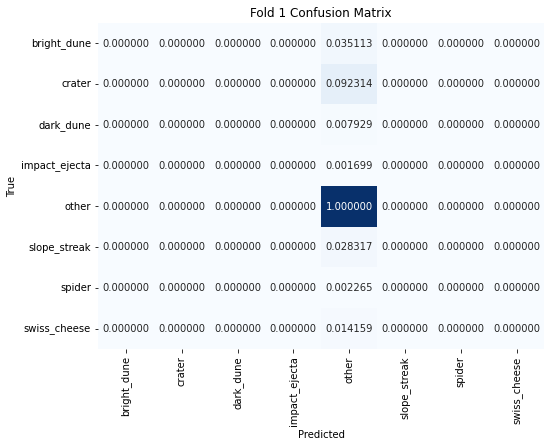

Found 58425 validated image filenames belonging to 8 classes.
Found 14606 validated image filenames belonging to 8 classes.
457/457 [==============================] - 8s 17ms/step


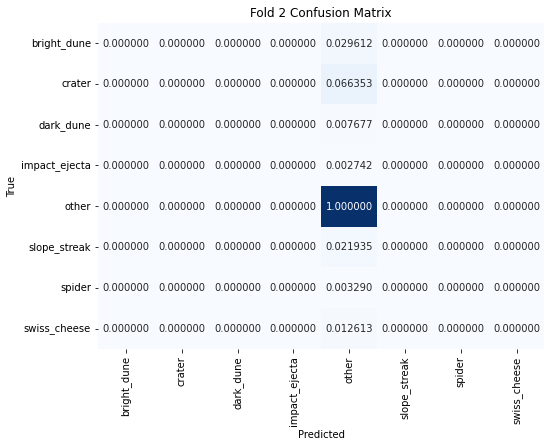

Found 58425 validated image filenames belonging to 8 classes.
Found 14606 validated image filenames belonging to 8 classes.
457/457 [==============================] - 9s 19ms/step


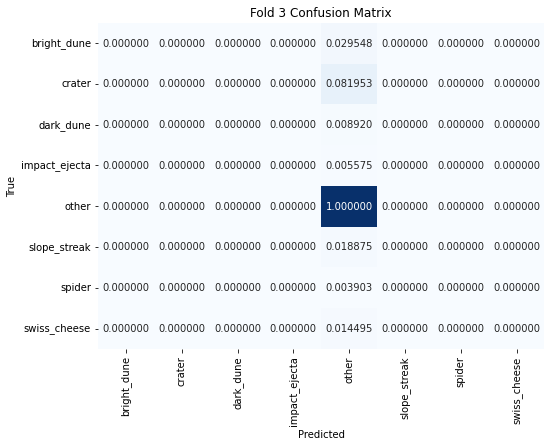

Found 58425 validated image filenames belonging to 8 classes.
Found 14606 validated image filenames belonging to 8 classes.
457/457 [==============================] - 9s 19ms/step


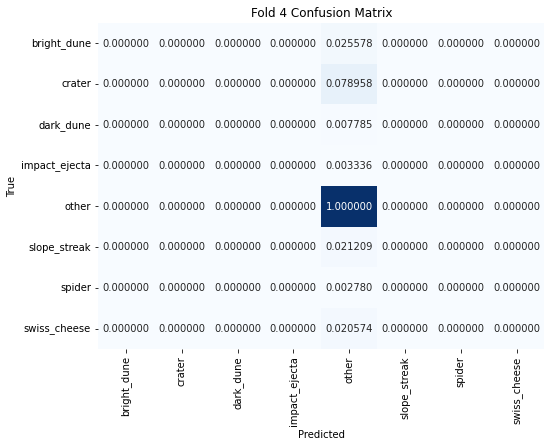

Found 58425 validated image filenames belonging to 8 classes.
Found 14606 validated image filenames belonging to 8 classes.
457/457 [==============================] - 9s 19ms/step


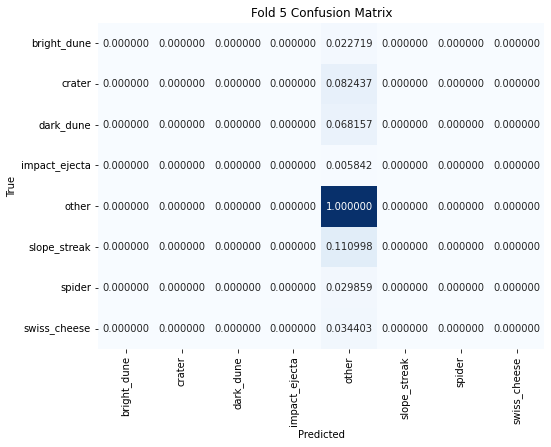

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

fold_var = 1
n=73031
num_epochs = 10
img_width = 227
img_height = 227

for train_index, val_index in kf.split(np.zeros(n),Y):
    training_data = train_data.iloc[train_index]
    validation_data = train_data.iloc[val_index]
	
    train_data_generator = idg.flow_from_dataframe(training_data, directory = image_dir,
						       x_col = "filename", y_col = "label", target_size=(img_height, img_width),
						       class_mode = "categorical", shuffle = True)
    valid_data_generator  = idg.flow_from_dataframe(validation_data, directory = image_dir,
							x_col = "filename", y_col = "label", target_size=(img_height, img_width),
							class_mode = "categorical", shuffle = True)
    
    class_labels = list(valid_data_generator.class_indices.keys())
    
    load_trained_model(save_dir + "/model_" + str(fold_var) + ".h5")
    
    # perform validation predictions
    val_predictions = model.predict(valid_data_generator)
    # Convert predicted probabilities to class labels
    predicted_labels = np.argmax(val_predictions, axis=1)
    
    # generate confusion matrix
    confusion = confusion_matrix(valid_data_generator.classes, predicted_labels)
    
    # plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion / confusion.astype(float).sum(axis=1), annot=True, fmt="f", cmap="Blues", cbar=False,
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Fold ' + str(fold_var) +  ' Confusion Matrix')
    plt.show()
    
    fold_var += 1